In [1]:
import math
import random
from os import path
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.display import display
from sklearn.metrics import (accuracy_score, f1_score, precision_recall_curve,
                             precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from torch.utils.data import DataLoader, TensorDataset

In [2]:
SEED = 491
N_SYN = 10000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
DATA_PATH = "../../data/previous"
SEER_FILE = path.join(DATA_PATH, "processed_seer_with_age.csv")
COHORT_FILE = path.join(DATA_PATH, "processed_cohort_with_age.csv")

LABEL_COL = "target"
DISCRETE_COLS = ["age", "clinical_stage", "ISUP_grade", "biopsy_cores_positive", "biopsy_cores_examined"]

In [4]:
seer_df = pl.read_csv(SEER_FILE)
cohort_df = pl.read_csv(COHORT_FILE)

FEATURE_COLS = [c for c in seer_df.columns if c != LABEL_COL]
DISCRETE_INDICES = [FEATURE_COLS.index(c) for c in DISCRETE_COLS]

X_seer_raw = seer_df.select(FEATURE_COLS).to_numpy().astype(np.float32)
y_seer = seer_df.get_column(LABEL_COL).to_numpy().astype(np.int64)

X_cohort_raw = cohort_df.select(FEATURE_COLS).to_numpy().astype(np.float32)
y_cohort = cohort_df.get_column(LABEL_COL).to_numpy().astype(np.int64)

X_train_raw, X_test_raw, y_train_seer, y_test_seer = train_test_split(
    X_seer_raw, y_seer, test_size=0.2, random_state=SEED, stratify=y_seer
)

scaler_seer = StandardScaler().fit(X_train_raw)

X_train_seer_std = scaler_seer.transform(X_train_raw)
X_test_seer_std = scaler_seer.transform(X_test_raw)
X_cohort_std = scaler_seer.transform(X_cohort_raw)

X_seer_std = X_train_seer_std
y_seer = y_train_seer

print(f"SEER Train: {X_train_seer_std.shape}, SEER Test: {X_test_seer_std.shape}, Cohort: {X_cohort_std.shape}")

SEER Train: (24737, 6), SEER Test: (6185, 6), Cohort: (196, 6)


In [5]:
def evaluate(y_true, y_prob, name):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    f1_scores = 2 * recall * precision / (recall + precision + 1e-10)
    best_thresh = thresholds[np.argmax(f1_scores)]
    y_pred = (y_prob >= best_thresh).astype(int)
    return {
        "Model": name,
        "AUC": roc_auc_score(y_true, y_prob),
        "F1": f1_score(y_true, y_pred),
        "Prec": precision_score(y_true, y_pred, zero_division=0),
        "Rec": recall_score(y_true, y_pred)
    }

In [6]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.005, 0.01, 0.05],
}

grid = GridSearchCV(
    SVC(kernel='rbf', probability=False, class_weight="balanced", random_state=SEED),
    param_grid,
    scoring='roc_auc',
    cv=4,
    n_jobs=-1
)

grid.fit(X_seer_std, y_seer)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",SVC(class_wei...dom_state=491)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'C': [0.1, 1, ...], 'gamma': [0.005, 0.01, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",4
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >3 : the

In [7]:
best_params = grid.best_params_
print(best_params)
display(pl.DataFrame(grid.cv_results_, strict=False))

{'C': 1, 'gamma': 0.01}


mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
f64,f64,f64,f64,f64,f64,struct[2],f64,f64,f64,f64,f64,f64,i32
28.253573,5.339622,3.675489,0.536288,0.1,0.005,"{0.1,0.005}",0.822482,0.834133,0.816857,0.798521,0.817998,0.012856,7
29.547175,7.019251,3.218709,0.154059,0.1,0.01,"{0.1,0.01}",0.823963,0.836524,0.819106,0.801286,0.82022,0.012645,5
21.567364,0.41514,2.996647,0.069176,0.1,0.05,"{0.1,0.05}",0.822425,0.834347,0.81936,0.801628,0.81944,0.011709,6
21.594283,1.622828,2.987471,0.11391,1.0,0.005,"{1.0,0.005}",0.824654,0.838344,0.820103,0.80258,0.82142,0.012783,3
20.38253,1.828773,4.232984,0.119032,1.0,0.01,"{1.0,0.01}",0.825513,0.837961,0.820964,0.803561,0.822,0.012331,1
24.270802,2.869096,3.001127,0.56229,1.0,0.05,"{1.0,0.05}",0.819375,0.831779,0.813569,0.794338,0.814765,0.013504,8
21.283658,2.230125,2.868795,0.463141,10.0,0.005,"{10.0,0.005}",0.825106,0.8386,0.820549,0.803372,0.821907,0.012592,2
17.796444,1.54033,1.529245,0.066162,10.0,0.01,"{10.0,0.01}",0.825739,0.837046,0.8189,0.803484,0.821292,0.012153,4
12.125059,1.34165,1.450408,0.136747,10.0,0.05,"{10.0,0.05}",0.810756,0.823053,0.805511,0.782765,0.805521,0.0146,9


In [8]:
svm = SVC(
    kernel='rbf',
    probability=True,
    class_weight="balanced",
    random_state=SEED,
    C=best_params["C"],
    gamma=best_params["gamma"]
)
svm.fit(X_seer_std, y_seer)

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",0.01
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",True
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",'balanced'
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [9]:
svm_probs = svm.predict_proba(X_cohort_std)[:, 1]
res_svm = evaluate(y_cohort, svm_probs, f"SVM (Best: {grid.best_params_})")
display(pl.DataFrame(res_svm))

Model,AUC,F1,Prec,Rec
str,f64,f64,f64,f64
"""SVM (Best: {'C': 1, 'gamma': 0…",0.80955,0.505051,0.384615,0.735294


In [10]:
class CVAE(nn.Module):
    def __init__(self, in_dim, lat_dim=16):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(in_dim + 1, 32), nn.ReLU(), nn.Linear(32, 16), nn.ReLU())
        self.mu = nn.Linear(16, lat_dim)
        self.logvar = nn.Linear(16, lat_dim)
        self.dec = nn.Sequential(nn.Linear(lat_dim + 1, 16), nn.ReLU(), nn.Linear(16, 32), nn.ReLU(), nn.Linear(32, in_dim))

    def encode(self, x, c):
        h = self.enc(torch.cat([x, c], 1))
        return self.mu(h), self.logvar(h)

    def reparam(self, mu, logvar):
        return mu + torch.randn_like(mu) * torch.exp(0.5 * logvar)

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparam(mu, logvar)
        return self.dec(torch.cat([z, c], 1)), mu, logvar

In [11]:
LATENT_DIM = 16
in_dim = X_seer_std.shape[1]
ds = TensorDataset(
    torch.tensor(X_train_seer_std).to(DEVICE),
    torch.tensor(y_train_seer, dtype=torch.float32).view(-1, 1).to(DEVICE)
)
dl = DataLoader(ds, batch_size=128, shuffle=True)

In [12]:
cvae = CVAE(in_dim, LATENT_DIM).to(DEVICE)
opt_cvae = optim.Adam(cvae.parameters(), lr=1e-3)

In [49]:
for _ in range(100):
    for x, c in dl:
        recon, mu, logvar = cvae(x, c)
        kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        loss = nn.MSELoss()(recon, x) + 0.01 * kl
        opt_cvae.zero_grad(); loss.backward(); opt_cvae.step()

In [50]:
class GAN_G(nn.Module):
    def __init__(self, lat_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(lat_dim + 1, 64), nn.ReLU(), nn.Linear(64, 64), nn.ReLU(), nn.Linear(64, out_dim))
    def forward(self, z, c): return self.net(torch.cat([z, c], 1))

class GAN_D(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(in_dim + 1, 64), nn.LeakyReLU(0.2), nn.Linear(64, 32), nn.LeakyReLU(0.2), nn.Linear(32, 1), nn.Sigmoid())
    def forward(self, x, c): return self.net(torch.cat([x, c], 1))

In [51]:
netG = GAN_G(LATENT_DIM, in_dim).to(DEVICE)
netD = GAN_D(in_dim).to(DEVICE)
optG = optim.Adam(netG.parameters(), lr=2e-4)
optD = optim.Adam(netD.parameters(), lr=2e-4)
criterion = nn.BCELoss()

In [52]:
for _ in range(100):
    for x, c in dl:
        bs = x.size(0)
        z = torch.randn(bs, LATENT_DIM).to(DEVICE)
        fake_c = torch.randint(0, 2, (bs, 1)).float().to(DEVICE)
        fake_x = netG(z, fake_c)

        optD.zero_grad()
        lossD = criterion(netD(x, c), torch.ones(bs, 1).to(DEVICE)) + criterion(netD(fake_x.detach(), fake_c), torch.zeros(bs, 1).to(DEVICE))
        lossD.backward(); optD.step()

        optG.zero_grad()
        lossG = criterion(netD(fake_x, fake_c), torch.ones(bs, 1).to(DEVICE))
        lossG.backward(); optG.step()

In [53]:
with torch.no_grad():
    c_syn = torch.randint(0, 2, (N_SYN, 1)).float().to(DEVICE)
    z = torch.randn(N_SYN, LATENT_DIM).to(DEVICE)

    x_cvae = cvae.dec(torch.cat([z, c_syn], 1)).cpu().numpy()
    x_gan = netG(z, c_syn).cpu().numpy()

syn_datasets = {
    "CVAE": (scaler_seer.inverse_transform(x_cvae), c_syn.cpu().numpy().flatten()),
    "GAN": (scaler_seer.inverse_transform(x_gan), c_syn.cpu().numpy().flatten())
}

for name, (X_syn, y_syn) in syn_datasets.items():
    for idx in DISCRETE_INDICES:
        X_syn[:, idx] = np.round(X_syn[:, idx])

    X_syn[:, FEATURE_COLS.index("ISUP_grade")] = np.clip(X_syn[:, FEATURE_COLS.index("ISUP_grade")], 1, 5)
    X_syn[:, FEATURE_COLS.index("clinical_stage")] = np.clip(X_syn[:, FEATURE_COLS.index("clinical_stage")], 1, 4)
    X_syn[:, FEATURE_COLS.index("biopsy_cores_positive")] = np.clip(X_syn[:, FEATURE_COLS.index("biopsy_cores_positive")], 0, 20)

    syn_datasets[name] = (X_syn, y_syn)

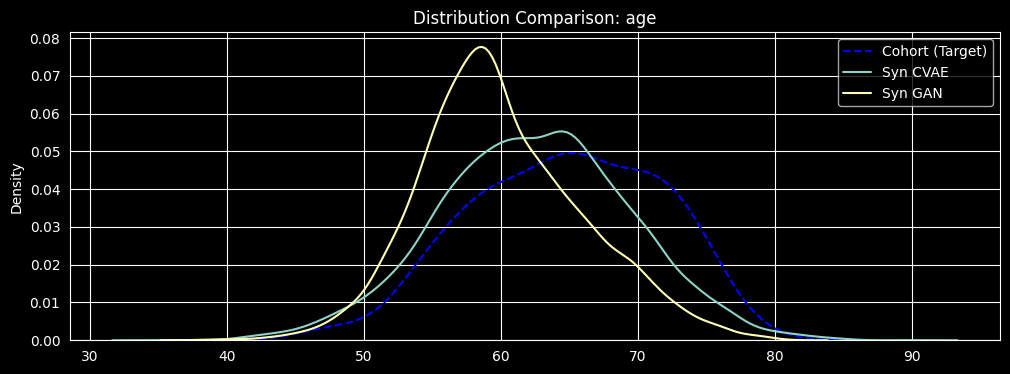

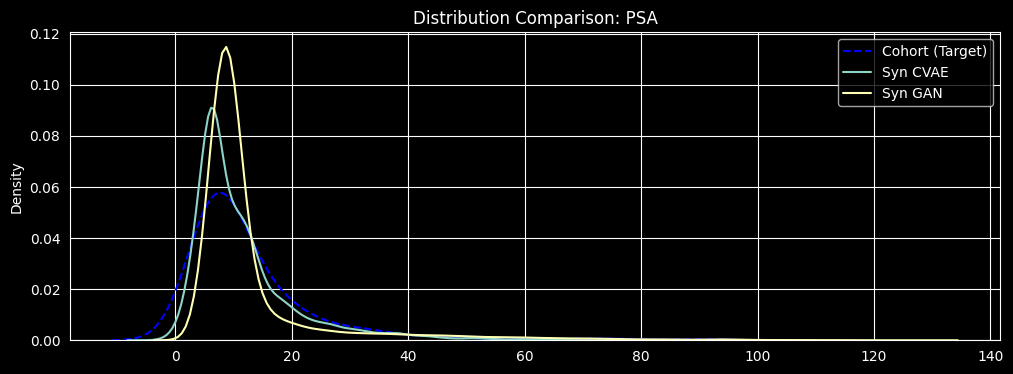

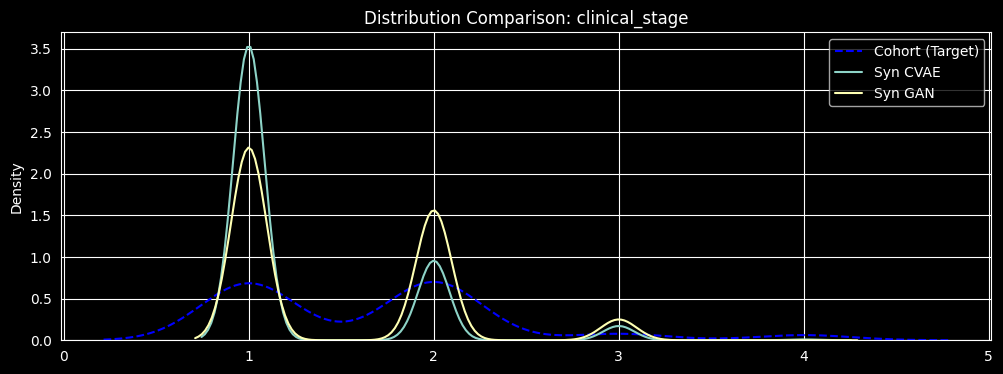

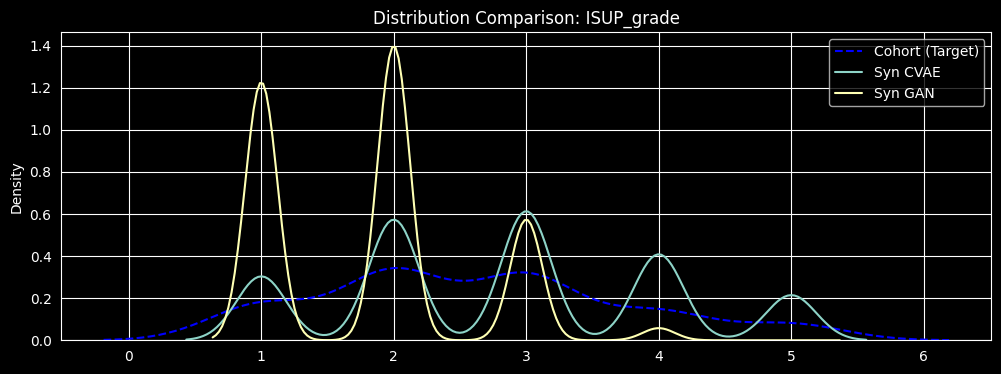

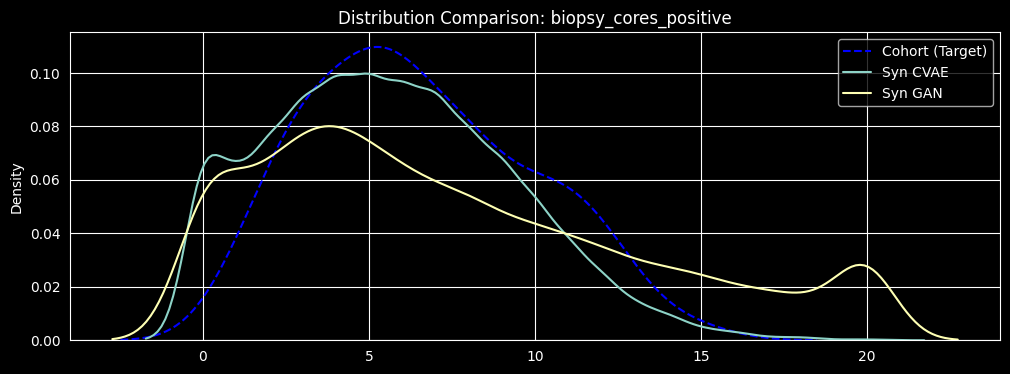

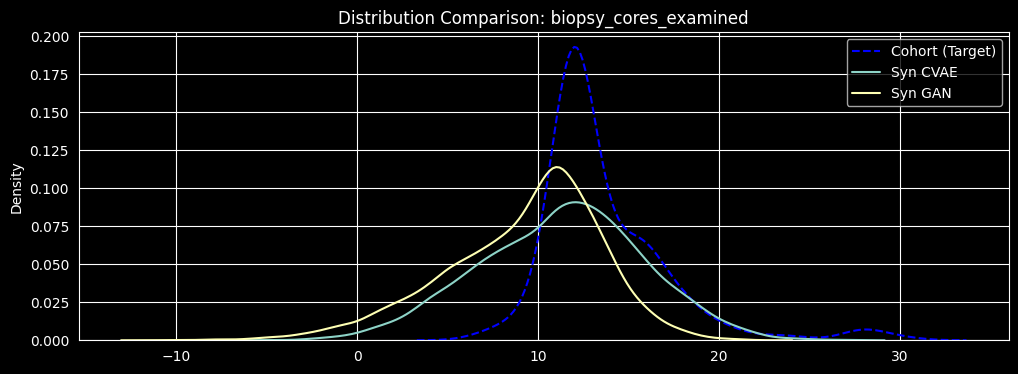

In [54]:
for col in FEATURE_COLS:
    plt.figure(figsize=(12, 4))
    # sns.kdeplot(seer_df[col], label="SEER (Real)", color="white", bw_adjust=0.5)
    sns.kdeplot(cohort_df[col], label="Cohort (Target)", color="blue", linestyle="--")

    for name, (X_syn, _) in syn_datasets.items():
        sns.kdeplot(X_syn[:, FEATURE_COLS.index(col)], label=f"Syn {name}")

    plt.title(f"Distribution Comparison: {col}")
    plt.legend()
    plt.show()

In [55]:
results_final = []

for name, (X_syn_raw, y_syn) in syn_datasets.items():
    syn_scaler = StandardScaler().fit(X_syn_raw)
    X_syn_std = syn_scaler.transform(X_syn_raw)

    clf_syn = SVC(kernel='rbf', probability=True, class_weight="balanced",
                  random_state=SEED, **best_params)
    clf_syn.fit(X_syn_std, y_syn)

    p_seer = clf_syn.predict_proba(X_test_seer_std)[:, 1]
    results_final.append(evaluate(y_test_seer, p_seer, f"{name} -> SEER Test"))

    p_cohort = clf_syn.predict_proba(X_cohort_std)[:, 1]
    results_final.append(evaluate(y_cohort, p_cohort, f"{name} -> Cohort"))
ref_probs = svm.predict_proba(X_test_seer_std)[:, 1]
results_final.append(evaluate(y_test_seer, ref_probs, "REAL SEER -> SEER Test"))

In [56]:
display(pl.DataFrame(results_final))

Model,AUC,F1,Prec,Rec
str,f64,f64,f64,f64
"""CVAE -> SEER Test""",0.821271,0.365325,0.337786,0.397753
"""CVAE -> Cohort""",0.784495,0.466667,0.375,0.617647
"""GAN -> SEER Test""",0.720349,0.25853,0.182576,0.442697
"""GAN -> Cohort""",0.684822,0.385965,0.478261,0.323529
"""REAL SEER -> SEER Test""",0.839234,0.395793,0.344426,0.465169


In [96]:
class TransferNet(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
        nn.Linear(in_dim, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 1),
        nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)

def train_nn(model, dl, epochs, lr):
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    crit = nn.BCELoss()
    model.train()
    for _ in range(epochs):
        for xb, yb in dl:
            opt.zero_grad()
            crit(model(xb), yb).backward()
            opt.step()

In [97]:
def reset_seeds():
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [98]:
X_train_cohort_raw, X_test_cohort_raw, y_train_cohort, y_test_cohort = train_test_split(
    X_cohort_raw, y_cohort, test_size=0.4, random_state=SEED, stratify=y_cohort
)

print(f"Cohort Train: {X_train_cohort_raw.shape}, Cohort Test: {X_test_cohort_raw.shape}")

Cohort Train: (117, 6), Cohort Test: (79, 6)


In [110]:
results = []

for name, (X_syn_raw, y_syn) in syn_datasets.items():
    scl = StandardScaler().fit(X_syn_raw)

    X_syn_t = torch.tensor(scl.transform(X_syn_raw), dtype=torch.float32).to(DEVICE)
    y_syn_t = torch.tensor(y_syn, dtype=torch.float32).view(-1, 1).to(DEVICE)
    X_tr_c = torch.tensor(scl.transform(X_train_cohort_raw), dtype=torch.float32).to(DEVICE)
    y_tr_c = torch.tensor(y_train_cohort, dtype=torch.float32).view(-1, 1).to(DEVICE)
    X_te_c = torch.tensor(scl.transform(X_test_cohort_raw), dtype=torch.float32).to(DEVICE)

    reset_seeds()
    model = TransferNet(in_dim).to(DEVICE)

    train_nn(model, DataLoader(TensorDataset(X_syn_t, y_syn_t), 32, shuffle=True, num_workers=0), 40, 0.0001)
    train_nn(model, DataLoader(TensorDataset(X_tr_c, y_tr_c), 32, shuffle=True, num_workers=0), 20, 0.001)

    model.eval()
    with torch.no_grad():
        probs = model(X_te_c).cpu().numpy().flatten()
    results.append(evaluate(y_test_cohort, probs, f"FT ({name})"))

reset_seeds()
base_model = TransferNet(in_dim).to(DEVICE)
train_nn(base_model, DataLoader(TensorDataset(X_tr_c, y_tr_c), 32, shuffle=True, num_workers=0), 20, 0.001)

base_model.eval()
with torch.no_grad():
    probs_base = base_model(X_te_c).cpu().numpy().flatten()
results.append(evaluate(y_test_cohort, probs_base, "Baseline NN"))

display(pl.DataFrame(results).sort("F1", descending=True))

Model,AUC,F1,Prec,Rec
str,f64,f64,f64,f64
"""FT (GAN)""",0.82967,0.590909,0.433333,0.928571
"""Baseline NN""",0.827473,0.571429,0.47619,0.714286
"""FT (CVAE)""",0.807692,0.536585,0.407407,0.785714
